# Rock Paper Scissors (using MobileNetV2)

> We build a CNN model using Tensorflow to recognize Rock-Paper-Scissors

## We use Transfer Learning using MobileNetV2, which is pretrained on ImageNet and produces one of the SOTA results for image classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Cutout, Rotate, Normalize,ToFloat
)
#from albumentations.pytorch import ToTensor, ToTensorV2

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Python version: 3.7.6
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
# load tensorboard
%load_ext tensorboard

In [3]:
# Clear any logs from previous runs.
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# checking current directory
pathlib.Path.cwd()

# 1. Load Data
##### https://www.tensorflow.org/datasets/overview

In [4]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='data',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [6]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

In [7]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

NUM_CLASSES = dataset_info.features['label'].num_classes
print('Number of label classes:', NUM_CLASSES)

Raw train dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 

Number of label classes: 3


# 2. Resize the image

In [8]:
dataset_info.features['image']

Image(shape=(300, 300, 3), dtype=tf.uint8)

In [9]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0] # 300
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape #(300,300,3)

# For MobilenetV2, possible input sizes are [96, 128, 160, 192, 224].
INPUT_IMG_SIZE_REDUCED = 192
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 192
Input image shape (reduced): (192, 192, 3)


Input image size: 192
Input image shape: (192, 192, 3)


In [10]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [11]:
print(get_label_name(0));

print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


# 3. EDA

In [12]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        label = get_label_name(label.numpy())        
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

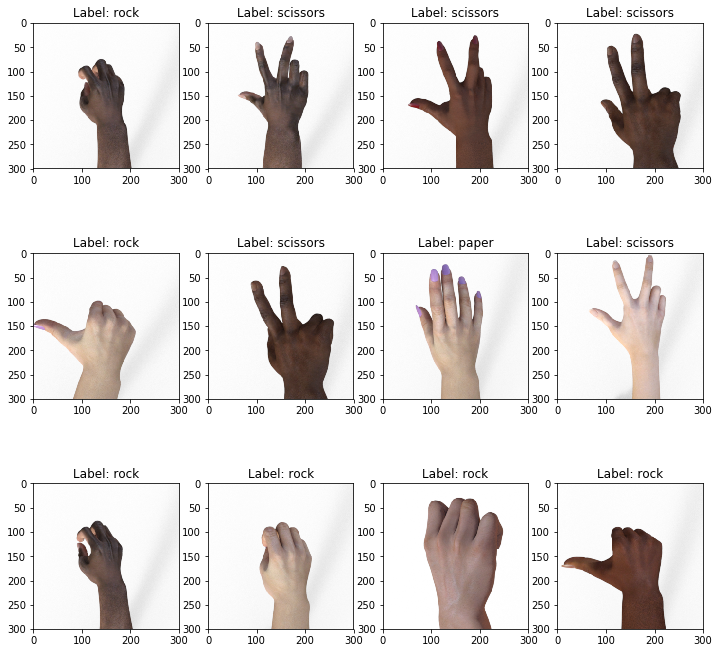

In [13]:
preview_dataset(dataset_train_raw)

# 4. Data Pre-processing

In [14]:
def Preprocess(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # scale img
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [15]:
dataset_train_cleaned = dataset_train_raw.map(Preprocess)
dataset_test_cleaned = dataset_test_raw.map(Preprocess)

In [16]:
(first_image, first_lable) = list(dataset_train_cleaned.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 0 

Image shape: (192, 192, 3) 

[[[0.9952857  0.9952857  0.9952857 ]
  [0.9947074  0.9947074  0.9947074 ]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.97704124 0.97704124 0.97704124]
  [0.9719861  0.9719861  0.9719861 ]
  [0.9710938  0.9710938  0.9710938 ]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9927696  0.9927696  0.9927696 ]
  [0.99742264 0.99742264 0.99742264]
  ...
  [0.9752374  0.9752374  0.9752374 ]
  [0.97855395 0.97855395 0.97855395]
  [0.9743145  0.9743145  0.9743145 ]]

 [[0.997055   0.997055   0.997055  ]
  [0.99498314 0.99498314 0.99498314]
  [0.9940487  0.9940487  0.9940487 ]
  ...
  [0.97552466 0.97552466 0.97552466]
  [0.970841   0.970841   0.970841  ]
  [0.9735677  0.9735677  0.9735677 ]]

 ...

 [[0.9893382  0.9893382  0.9893382 ]
  [0.9875038  0.9875038  0.9875038 ]
  [0.98749995 0.98749995 0.98749995]
  ...
  [0.9771178  0.9771178  0.9771178 ]
  [0.9781786  0.9781786  0.9781786 ]
  [0.9799441  0.9799441  0.9799441 ]]

 [[0.99078584 0.99078584 0.9907858

# Data augmentation
#### https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/#rotation-and-flipping
#### ToDo: Apply Albumentation Library

In [17]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [18]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [19]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [20]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [21]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [22]:
def Data_Augmentation(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [23]:
dataset_train_augmented = dataset_train_cleaned.map(Data_Augmentation)

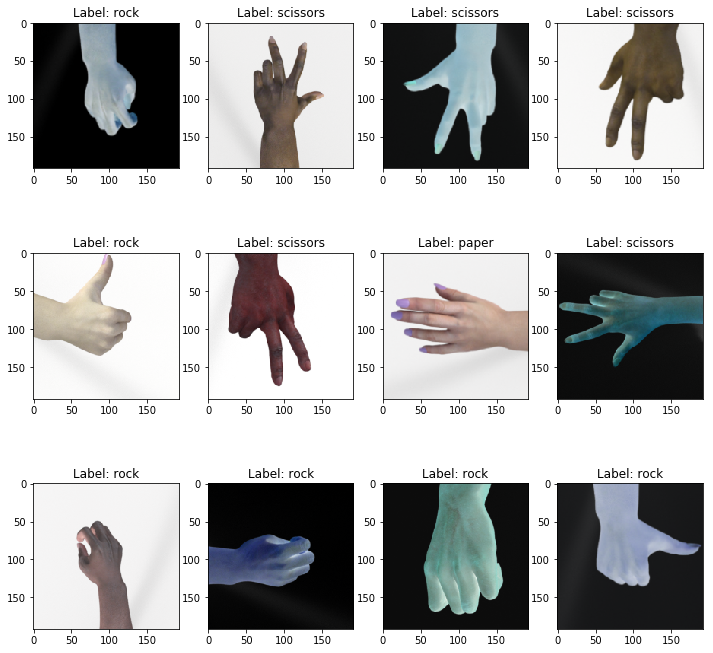

In [24]:
preview_dataset(dataset_train_augmented)

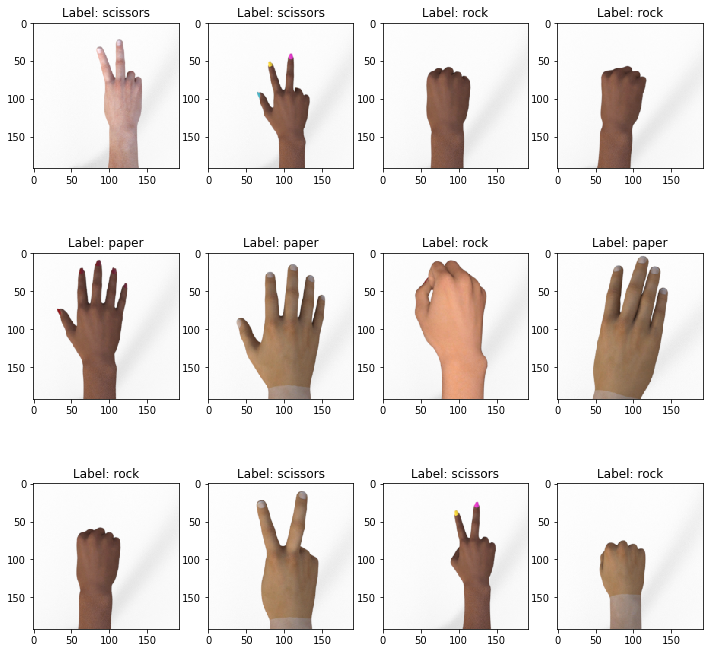

In [25]:
# Explore test dataset.
preview_dataset(dataset_test_cleaned)

# 5. Batch in Loader
### We don't want our model to learn anything from the order or grouping of the images in the dataset. To avoid that we will shuffle the training examples. 
### Also we're going to split the training set by batches to speed up training process and make it less memory consuming.

In [26]:
BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test_cleaned.batch(BATCH_SIZE)

In [27]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>


## 6. Create a model (with MobileNetV2 Transfer Learning)

> We don't want to use the top classification layer of the pre-trained MobileNetV2 model as it contains 1000 classes when we need only 3 (rock, paper and scissors). We will specify that by setting a include_top parameter to False.

In [28]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet', # If None, random initialization
  pooling='avg' # If None, output of the model will be the 4D tensor output of the last convolutional block. If max, global max pooling will be applied
)

In [29]:
# Freezing the base model since we don't want to re-train it.
# We're only interesting in its feature extraction.
base_model.trainable = False

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

> We add our own top-most classfiication layer (RPS 3 classes)

In [31]:
model = tf.keras.models.Sequential()

model.add(base_model)

model.add(tf.keras.layers.Dropout(0.5))

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## 7. Train the Model

In [34]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [35]:
!rm -rf checkpoints
!rm -rf logs

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
# Callbacks.
os.makedirs('logs/logs', exist_ok=True)
tensorboard_log_dir = 'logs/logs' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [37]:
initial_epochs = 30

In [38]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        #model_checkpoint_callback,
        #early_stopping_callback,
        tensorboard_callback
    ],
    verbose=True
)

Epoch 1/30
3/3 [==============================] - 51s 17s/step - loss: 1.4472 - accuracy: 0.3808 - val_loss: 1.1299 - val_accuracy: 0.3656
Epoch 2/30
3/3 [==============================] - 37s 12s/step - loss: 1.2009 - accuracy: 0.4721 - val_loss: 1.0317 - val_accuracy: 0.4435
Epoch 3/30
3/3 [==============================] - 28s 9s/step - loss: 1.0980 - accuracy: 0.5215 - val_loss: 0.9626 - val_accuracy: 0.5403
Epoch 4/30
3/3 [==============================] - 20s 7s/step - loss: 1.0196 - accuracy: 0.5680 - val_loss: 0.9282 - val_accuracy: 0.5618
Epoch 5/30
3/3 [==============================] - 32s 11s/step - loss: 0.9265 - accuracy: 0.6087 - val_loss: 0.9094 - val_accuracy: 0.5430
Epoch 6/30
3/3 [==============================] - 41s 14s/step - loss: 0.8655 - accuracy: 0.6349 - val_loss: 0.8932 - val_accuracy: 0.5269
Epoch 7/30
3/3 [==============================] - 27s 9s/step - loss: 0.8217 - accuracy: 0.6517 - val_loss: 0.8768 - val_accuracy: 0.5215
Epoch 8/30
3/3 [==============

In [39]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

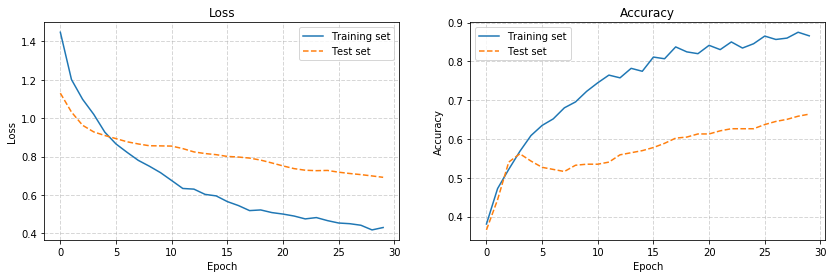

In [40]:
render_training_history(training_history)

In [41]:
## 8. Model fine tuning

In [42]:
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  156


In [43]:
# Fine tune from this layer onwards.
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
# or try rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [44]:
# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10

In [45]:
training_history_fine = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs + fine_tuning_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Epoch 31/40
3/3 [==============================] - 39s 13s/step - loss: 0.3128 - accuracy: 0.9154 - val_loss: 0.6991 - val_accuracy: 0.6774
Epoch 32/40
3/3 [==============================] - 47s 16s/step - loss: 0.2505 - accuracy: 0.9366 - val_loss: 0.7469 - val_accuracy: 0.6613
Epoch 33/40
3/3 [==============================] - 32s 11s/step - loss: 0.2290 - accuracy: 0.9535 - val_loss: 0.7650 - val_accuracy: 0.6694
Epoch 34/40
3/3 [==============================] - 23s 8s/step - loss: 0.1992 - accuracy: 0.9605 - val_loss: 0.7774 - val_accuracy: 0.6855
Epoch 35/40
3/3 [==============================] - 42s 14s/step - loss: 0.1818 - accuracy: 0.9658 - val_loss: 0.7830 - val_accuracy: 0.6882
Epoch 36/40
3/3 [==============================] - 46s 15s/step - loss: 0.1716 - accuracy: 0.9674 - val_loss: 0.7719 - val_accuracy: 0.6989
Epoch 37/40
3/3 [==============================] - 34s 11s/step - loss: 0.1539 - accuracy: 0.9756 - val_loss: 0.7591 - val_accuracy: 0.7231
Epoch 38/40
3/3 [====

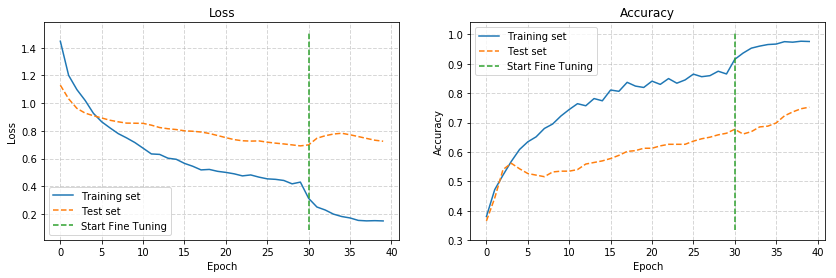

In [46]:
loss = training_history.history['loss'] + training_history_fine.history['loss']
val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']

accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## 9. Check result in Tensorboard

In [47]:
%tensorboard --logdir logs/fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 42840.

## 10. Evaluate accuracy

In [49]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train_cleaned.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test_cleaned.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

1/1 [==============================] - 0s 2ms/step - loss: 0.7253 - accuracy: 0.7527


In [50]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.21351639926433563
Training accuracy:  0.9535714387893677


Test loss:  0.7253485918045044
Test accuracy:  0.7526881694793701


## Save Model

In [ ]:
model_name = 'rock_paper_scissors_mobilenet_v2.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by tensorflowjs. To do so we may use tfjs-converter as following:

tensorflowjs_converter --input_format keras \
  ./experiments/rock_paper_scissors_mobilenet_v2/rock_paper_scissors_mobilenet_v2.h5 \
  ./demos/public/models/rock_paper_scissors_mobilenet_v2

### Reference
#### https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_mobilenet_v2/rock_paper_scissors_mobilenet_v2.ipynb
#### https://www.tensorflow.org/tutorials/images/transfer_learning